In [1]:
'''
1. データセットの読み込み
'''
# tensorflow.keras のインポート
from tensorflow import keras

# CIFAR-10データセットの読み込み
(x_train, t_train), (x_test, t_test) = keras.datasets.cifar10.load_data()

In [2]:
'''
2.モデルの作成
'''
class CNN(keras.Model):
    '''畳み込みニューラルネットワーク
    
    Attributes:
      l1(Dense): 隠れ層
      l2(Dense): 出力層
    '''
    def __init__(self, output_dim):
        '''
        Parameters:
          output_dim(int): 出力層のユニット数(次元)
          
        Attributes:
          c1(Conv2D): 畳み込み層1
          p1(MaxPooling2D): プーリング層1
          c2(Conv2D): 畳み込み層2
          p2(MaxPooling2D): プーリング層2
          c3(Conv2D): 畳み込み層3
          p3(MaxPooling2D): プーリング層2
          f1(Flatten): Flatten
          d1(Dropout): ドロップアウト1          
          l1(Dense): 全結合層          
          l2(Dense): 出力層
        '''
        super().__init__()
        
        # 正則化の係数
        weight_decacy = 1e-4

        # (第1層)畳み込み層1 正則化を行う
        self.c1 = keras.layers.Conv2D(
            filters=64,                   # フィルター数64
            kernel_size=(3, 3),           # 3×3のフィルター
            padding='same',               # ゼロパディング
            input_shape=x_train[0].shape, # 入力データの形状
            kernel_regularizer=keras.regularizers.l2(
                weight_decacy), # 正則化
            activation='relu'             # 活性化関数はReLU
            )

        # (第2層)プーリング層1：ウィンドウサイズは2×2
        self.p1 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))             # 縮小対象の領域は2×2

        # (第3層)畳み込み層2　正則化を行う
        self.c2 = keras.layers.Conv2D(
            filters=128,                  # フィルターの数は128
            kernel_size=(3, 3),           # 3×3のフィルターを使用
            padding='same',               # ゼロパディングを行う
            kernel_regularizer=keras.regularizers.l2(
                weight_decacy),           # 正則化
            activation='relu'             # 活性化関数はReLU
            )
 
        # (第4層)プーリング層2：ウィンドウサイズは2×2
        self.p2 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))             # 縮小対象の領域は2×2       
        
        # (第5層)畳み込み層3　正則化を行う
        self.c3 = keras.layers.Conv2D(
            filters=256,                  # フィルターの数は256
            kernel_size=(3, 3),           # 3×3のフィルターを使用
            padding='same',               # ゼロパディングを行う
            kernel_regularizer=keras.regularizers.l2(weight_decacy), # 正則化
            activation='relu'             # 活性化関数はReLU
            )

        # (第6層)プーリング層3：ウィンドウサイズは2×2
        self.p3 = keras.layers.MaxPooling2D(
            pool_size=(2, 2))             # 縮小対象の領域は2×2
       
        # Flaten
        # ニューロン数＝7×7×16=784
        # (7, 7, 64)を(784)にフラット化
        self.f1 = keras.layers.Flatten()

        # ドロップアウト：ドロップアウトは40％
        self.d1 = keras.layers.Dropout(0.4)

        # （第7層）全結合層
        self.l1 =  keras.layers.Dense(
            512,                          # 出力層のニューロン数は512
            activation='relu')            # 活性化関数はソフトマックス

        # （第8層）出力層
        self.l2 =  keras.layers.Dense(
            10,                           # 出力層のニューロン数は10
            activation='softmax')         # 活性化関数はソフトマックス
        
        # すべての層をリストにする
        self.ls = [self.c1, self.p1, self.c2, self.p2, self.c3, self.p3,
                   self.f1, self.d1, self.l1, self.l2]

    def call(self, x):
        '''CNNのインスタンスからコールバックされる関数
        
        Parameters: x(ndarray(float32)):訓練データ、または検証データ
        Returns(float32): CNNの出力として要素数10の1階テンソル        
        '''
        for layer in self.ls:
            x = layer(x)
        
        return x

In [3]:
'''
3.損失関数の定義
'''
# 損失関数はスパースラベル対応クロスエントロピー誤差
cce = keras.losses.SparseCategoricalCrossentropy()

def loss(t, y):
    '''損失関数
    Parameters: t(ndarray(float32)):正解ラベル
                y(ndarray(float32)):予測値
                
    Returns: クロスエントロピー誤差
    '''
    return cce(t, y)

In [4]:
'''
4.オプティマイザーのオブジェクトの生成
  損失と精度を測定するオブジェクトの生成
'''
# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = keras.optimizers.SGD(learning_rate=0.1)

# 損失を記録するオブジェクトを生成
train_loss = keras.metrics.Mean()
# 精度を記録するオブジェクトを生成
train_acc = keras.metrics.SparseCategoricalAccuracy()
# 検証時の損失を記録するオブジェクトを生成
val_loss = keras.metrics.Mean()
# 検証時の精度を記録するオブジェクトを生成
val_acc = keras.metrics.SparseCategoricalAccuracy()

In [5]:
'''
5.勾配降下アルゴリズムによるパラメーターの更新処理
'''
import tensorflow as tf

def train_step(x, t):
    '''学習を1回行う
    
    Parameters: x(ndarray(float32)):訓練データ
                t(ndarray(float32)):正解ラベル
                
    Returns:
      ステップごとのクロスエントロピー誤差
    '''
    # 自動微分による勾配計算を記録するブロック
    with tf.GradientTape() as tape:
        # モデルに入力して順伝搬の出力値を取得
        outputs = model(x)
        # 出力値と正解ラベルの誤差
        tmp_loss = loss(t, outputs)
        
    # tapeに記録された操作を使用して誤差の勾配を計算        
    grads = tape.gradient(
        # 現在のステップの誤差
        tmp_loss,
        # バイアス、重みのリストを取得
        model.trainable_variables)
    # 勾配降下法の更新式を適用してバイアス、重みを更新
    optimizer.apply_gradients(zip(grads,
                                  model.trainable_variables))
    
    # 損失をMeanオブジェクトに記録
    train_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    train_acc(t, outputs)

In [6]:
'''
6. 検証データによる評価を行う関数
'''
def val_step(x, t):
    '''検証データをモデルに入力して損失と精度を測定
    
    Parameters: x(ndarray(float32)):検証データ
                t(ndarray(float32)):正解ラベル
    '''
    # 検証データの予測値を取得
    preds = model(x)
    # 出力値と正解ラベルの誤差
    tmp_loss = loss(t, preds)
    # 損失をMeanオブジェクトに記録
    val_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    val_acc(t, preds)

In [7]:
'''
7.学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            # カウンターを1増やす
            self.epoch += 1
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                # 早期終了のフラグが1の場合
                if self.verbose:
                    # メッセージを出力
                    print('early stopping')
                # 学習を終了するTrueを返す
                return True
        # 前エポックの損失以下の場合
        else:
            # カウンターを0に戻す
            self.epoch = 0
            # 損失の値を更新する
            self.pre_loss = current_loss
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

In [8]:
%%time
'''
8.モデルを生成して学習する
'''
from sklearn.utils import shuffle

# エポック数
epochs = 100
# ミニバッチのサイズ
batch_size = 64
# 訓練のステップ数
train_steps = len(x_train)*0.8 / batch_size
# 検証のステップ数
val_steps = len(x_train)*0.2 / batch_size
# 訓練と検証における損失と精度の推移を記録するdictオブジェクト
history = {'loss':[], 'accuracy':[],
           'val_loss':[], 'val_accuracy': []}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=20, # 監視対象回数
                    verbose=1)   # 早期終了時にメッセージを出力

# 出力層10ニューロンのモデルを生成
model = CNN(10)

# ImageDataGeneratorを生成
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,      # ピクセル値を255で割って正規化する
    validation_split=0.2,   # 20パーセントのデータを検証用にする
    rotation_range=15,      # 15度の範囲でランダムに回転させる
    width_shift_range=0.1,  # 横サイズの0.1の割合でランダムに水平移動
    height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
    horizontal_flip=True,  # 水平方向にランダムに反転、左右の入れ替え
    zoom_range=0.2,         # ランダムに拡大
)

# 訓練データ用のジェネレーターを生成
training_generator = datagen.flow(x_train, t_train,
                                  batch_size=batch_size,
                                  subset='training')      # 訓練用のデータを生成
# 検証データ用のジェネレーターを生成
validation_generator = datagen.flow(x_train, t_train,
                                    batch_size=batch_size,
                                    subset='validation') # 検証用のデータを生成

# 学習を行う
for epoch in range(epochs):
    # 訓練時のステップカウンター  
    step_counter = 0  
    # 1ステップ毎にミニバッチで学習する
    for x_batch, t_batch in training_generator:
        # ミニバッチでバイアス、重みを更新
        train_step(x_batch, t_batch)
        step_counter += 1
        # すべてのステップが終了したらbreak
        if step_counter >= train_steps:
            break
    
    # 検証時のステップカウンター
    v_step_counter = 0
    # 検証データによるモデルの評価
    for x_val_batch, t_val_batch  in validation_generator:
        # 検証データのミニバッチで損失と精度を測定
        val_step(x_val_batch, t_val_batch)
        v_step_counter += 1
        # すべてのステップが終了したらbreak
        if v_step_counter >= val_steps:
            break
   
    # 訓練と検証における損失と精度の推移をhistoryに記録
    history['loss'].append(train_loss.result())
    history['accuracy'].append(train_acc.result())
    history['val_loss'].append(val_loss.result())
    history['val_accuracy'].append(val_acc.result())
    
    # 1エポックごとに結果を出力
    print('epoch({}) train_loss: {:.4} train_acc: {:.4}'
          'val_loss: {:.4} val_acc: {:.4}'.format(
              epoch+1,
              train_loss.result(), # 訓練データの損失を出力
              train_acc.result(),  # 訓練データの精度を出力
              val_loss.result(),   # 検証データの損失を出力
              val_acc.result()     # 検証データの精度を出力
              ))
    
    # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
    if ers(val_loss.result()):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break

epoch(1) train_loss: 1.937 train_acc: 0.2963val_loss: 1.677 val_acc: 0.4156
epoch(2) train_loss: 1.725 train_acc: 0.3753val_loss: 1.527 val_acc: 0.4637
epoch(3) train_loss: 1.593 train_acc: 0.425val_loss: 1.454 val_acc: 0.4866
epoch(4) train_loss: 1.495 train_acc: 0.4627val_loss: 1.375 val_acc: 0.5143
epoch(5) train_loss: 1.417 train_acc: 0.4925val_loss: 1.309 val_acc: 0.5388
epoch(6) train_loss: 1.351 train_acc: 0.5171val_loss: 1.252 val_acc: 0.5599
epoch(7) train_loss: 1.295 train_acc: 0.5378val_loss: 1.206 val_acc: 0.5756
epoch(8) train_loss: 1.246 train_acc: 0.5561val_loss: 1.165 val_acc: 0.5895
epoch(9) train_loss: 1.203 train_acc: 0.5718val_loss: 1.132 val_acc: 0.601
epoch(10) train_loss: 1.164 train_acc: 0.5861val_loss: 1.104 val_acc: 0.6109
epoch(11) train_loss: 1.129 train_acc: 0.599val_loss: 1.086 val_acc: 0.6173
epoch(12) train_loss: 1.097 train_acc: 0.6107val_loss: 1.061 val_acc: 0.6265
epoch(13) train_loss: 1.067 train_acc: 0.6214val_loss: 1.038 val_acc: 0.6348
epoch(14) t

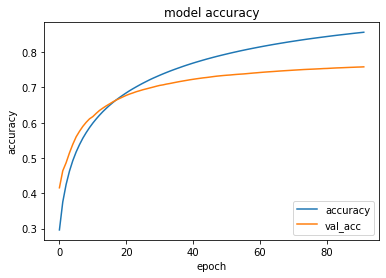

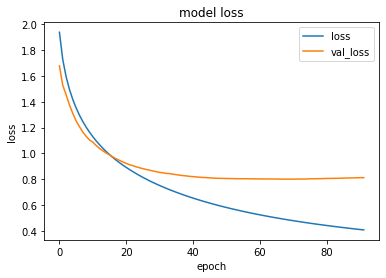

In [10]:
'''
9.損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history['accuracy'],"-",label="accuracy")
    plt.plot(history['val_accuracy'],"-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history['loss'],"-",label="loss",)
    plt.plot(history['val_loss'],"-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

# modelに学習させた時の変化の様子をplot
plot_history(history)

In [11]:
'''
10. テストデータによるモデルの評価
'''
# 損失を記録するオブジェクトを生成
test_loss = keras.metrics.Mean()
# 精度を記録するオブジェクトを生成
test_acc = keras.metrics.SparseCategoricalAccuracy()

def test_step(x, t):
    '''テストデータをモデルに入力して損失と精度を測定
    
    Parameters: x(ndarray(float32)):テストデータ
                t(ndarray(float32)):正解ラベル
    '''
    # テストデータの予測値を取得
    preds = model(x)
    # 出力値と正解ラベルの誤差
    tmp_loss = loss(t, preds)
    # 損失をMeanオブジェクトに記録
    test_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    test_acc(t, preds)

# テストデータを正規化
x_test =  x_test.astype('float32') / 255
# テストデータで予測して損失と精度を取得
test_step(x_test, t_test)

print('test_loss: {:.4f}, test_acc: {:.4f}'.format(
    test_loss.result(),
    test_acc.result()
))

test_loss: 0.7774, test_acc: 0.8284
